In [67]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import re
import seaborn as sns
from matplotlib import pyplot as plt

from Accuracy_scores import nucleotide_metrics, nucleotide_accuracy, site_accuracy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
predictions_df = pd.read_csv(os.path.join(os.getcwd(), 'CSVs/extraction/positions.csv'))
predictions_df['Target_Start_pos'] = pd.DataFrame([0 for _ in range(predictions_df.shape[0])])
predictions_df['Target_Stop_pos'] = pd.DataFrame([0 for _ in range(predictions_df.shape[0])])
predictions_df['Input_Sequence'] = pd.DataFrame(['' for _ in range(predictions_df.shape[0])])
predictions_df

,Subgroup,Position,Max_Value,Range,Target_Start_pos,Target_Stop_pos,Input_Sequence
0,Ada_1_209398-209425-forward,263,913.0,"range(256, 271)",0,0,
1,Ada_1_2145603-2145630-reverse,157,511.0,"range(150, 165)",0,0,
2,Ada_1_2308475-2308502-reverse,43,687.0,"range(36, 51)",0,0,
3,Ada_2_209398-209425-forward,24,121.0,"range(17, 32)",0,0,
4,Ada_2_2145603-2145630-reverse,386,96.0,"range(379, 394)",0,0,
...,...,...,...,...,...,...,...
2227,XylR_2_3728622-3728637-forward,115,821.0,"range(108, 123)",0,0,
2228,XylR_3_3728472-3728487-reverse,99,142.0,"range(92, 107)",0,0,
2229,XylR_3_3728622-3728637-forward,169,142.0,"range(162, 177)",0,0,
2230,XylR_5_3728472-3728487-reverse,150,80.0,"range(143, 158)",0,0,


In [3]:
dataset_path = os.path.join(os.getcwd(), 'Data/datasetB200')
input_files = os.listdir(dataset_path)

true_motifs_path = os.path.join(os.getcwd(), 'Data/ecoli.motifs')
ground_truth_motif_files = os.listdir(true_motifs_path)

In [11]:
def make_motif_group_df(text):
    headers = []
    sequences = []

    # Iterate over the lines
    for line in text:
        line = line.strip()
        if line.startswith('>'):
            # Extract the header (row starting with ">")
            headers.append(line[1:])
        else:
            # Extract the sequence
            sequences.append(line)

    # Create a DataFrame from the lists
    df = pd.DataFrame({'Sequence_ID': headers, 'Sequence': sequences})
    return df

for motif_group_file in input_files:
    filename = motif_group_file.split('.txt')[0]

    with open(os.path.join(dataset_path, motif_group_file), 'r') as file:
        motif_group = file.readlines()

    motif_group_df = make_motif_group_df(motif_group)

    col_names = ['ECK1', 'File_name', 'ECK2', 'Starting_position', 'Ending_position', 'Orientation',
                 'Association', 'Sequence', 'Additional', 'Label']
    targets_df = pd.read_csv(os.path.join(true_motifs_path, motif_group_file), sep='\t', names=col_names)
    targets_df['Sequence_ID'] = targets_df['Starting_position'].astype(str) + '-' + targets_df['Ending_position'].astype(str) + '-' + targets_df['Orientation']

    for idx, target_motif in targets_df.iterrows():
        seq_id = target_motif['Sequence_ID']
        seq_id_mask = motif_group_df['Sequence_ID'] == seq_id
        seq_index = list(motif_group_df[seq_id_mask].index)
        if len(seq_index) > 0:
            index = seq_index[0]
            input_sequence = str(motif_group_df.iloc[index]['Sequence']).strip()

            target_motif_sequence = target_motif['Sequence']
            uppercase_part = re.findall('[A-Z]+', target_motif_sequence)

            try:
                target_site = uppercase_part[0]
                target_site_start_pos = input_sequence.index(target_site)
                target_site_end_pos = target_site_start_pos + len(target_site)

                mask_predicted_seq_id = predictions_df['Subgroup'].str.contains(seq_id)
                predicted_sites = predictions_df[mask_predicted_seq_id]
                for pred_idx, row in predicted_sites.iterrows():
                    predictions_df.at[pred_idx, 'Target_Start_pos']= target_site_start_pos
                    predictions_df.at[pred_idx, 'Target_Stop_pos'] = target_site_end_pos
                    predictions_df['Input_Sequence'] = input_sequence
            except IndexError:
                print(filename, seq_id)
        else:
            pass

In [12]:
predictions_df['Predicted_Start_pos'] = predictions_df['Position']-7
predictions_df['Predicted_Stop_pos'] = predictions_df['Position']+7

predictions_df.to_csv(os.path.join(os.getcwd(), 'CSVs/extraction/positions_with_ground_truth.csv'), index=False, encoding='utf-8')

In [13]:
predictions_df

,Subgroup,Position,Max_Value,Range,Target_Start_pos,Target_Stop_pos,Input_Sequence,Predicted_Start_pos,Predicted_Stop_pos
0,Ada_1_209398-209425-forward,263,913.0,"range(256, 271)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,256,270
1,Ada_1_2145603-2145630-reverse,157,511.0,"range(150, 165)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,150,164
2,Ada_1_2308475-2308502-reverse,43,687.0,"range(36, 51)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,36,50
3,Ada_2_209398-209425-forward,24,121.0,"range(17, 32)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,17,31
4,Ada_2_2145603-2145630-reverse,386,96.0,"range(379, 394)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,379,393
...,...,...,...,...,...,...,...,...,...
2227,XylR_2_3728622-3728637-forward,115,821.0,"range(108, 123)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,108,122
2228,XylR_3_3728472-3728487-reverse,99,142.0,"range(92, 107)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,92,106
2229,XylR_3_3728622-3728637-forward,169,142.0,"range(162, 177)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,162,176
2230,XylR_5_3728472-3728487-reverse,150,80.0,"range(143, 158)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,143,157


In [8]:
predictions_df['nPC'] = pd.DataFrame([0 for _ in range(predictions_df.shape[0])])
predictions_df['nSn'] = pd.DataFrame([0 for _ in range(predictions_df.shape[0])])
predictions_df['nSp'] = pd.DataFrame([0 for _ in range(predictions_df.shape[0])])

for i, row in predictions_df.iterrows():
    start_pred = row['Predicted_Start_pos']
    stop_pred = row['Predicted_Stop_pos']
    start_true = row['Target_Start_pos']
    stop_true = row['Target_Stop_pos']
    seq_len = len(row['Input_Sequence']) - 1
    npc, nsn, nsp = nucleotide_metrics(start_pred, stop_pred, start_true, stop_true, seq_len)
    predictions_df.at[i, 'nPC'] = npc
    predictions_df.at[i, 'nSn'] = nsn
    predictions_df.at[i, 'nSp'] = nsp

predictions_df


,Subgroup,Position,Max_Value,Range,Target_Start_pos,Target_Stop_pos,Input_Sequence,Predicted_Start_pos,Predicted_Stop_pos,nPC,nSn,nSp
0,Ada_1_209398-209425-forward,263,913.0,"range(256, 271)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,256,270,0.0,0.0,0.0
1,Ada_1_2145603-2145630-reverse,157,511.0,"range(150, 165)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,150,164,0.0,0.0,0.0
2,Ada_1_2308475-2308502-reverse,43,687.0,"range(36, 51)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,36,50,0.0,0.0,0.0
3,Ada_2_209398-209425-forward,24,121.0,"range(17, 32)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,17,31,0.0,0.0,0.0
4,Ada_2_2145603-2145630-reverse,386,96.0,"range(379, 394)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,379,393,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2227,XylR_2_3728622-3728637-forward,115,821.0,"range(108, 123)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,108,122,0.0,0.0,0.0
2228,XylR_3_3728472-3728487-reverse,99,142.0,"range(92, 107)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,92,106,0.0,0.0,0.0
2229,XylR_3_3728622-3728637-forward,169,142.0,"range(162, 177)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,162,176,0.0,0.0,0.0
2230,XylR_5_3728472-3728487-reverse,150,80.0,"range(143, 158)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,143,157,0.0,0.0,0.0


In [9]:
predictions_df.to_csv(os.path.join(os.getcwd(), 'CSVs/extraction/positions_with_metrics.csv'), index=False, encoding='utf-8')

In [2]:
predictions_df = pd.read_csv(os.path.join(os.getcwd(), 'CSVs/extraction/positions_with_metrics.csv'))
predictions_df

,Subgroup,Position,Max_Value,Range,Target_Start_pos,Target_Stop_pos,Input_Sequence,Predicted_Start_pos,Predicted_Stop_pos,nPC,nSn,nSp
0,Ada_1_209398-209425-forward,263,913.0,"range(256, 271)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,256,270,0.0,0.0,0.0
1,Ada_1_2145603-2145630-reverse,157,511.0,"range(150, 165)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,150,164,0.0,0.0,0.0
2,Ada_1_2308475-2308502-reverse,43,687.0,"range(36, 51)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,36,50,0.0,0.0,0.0
3,Ada_2_209398-209425-forward,24,121.0,"range(17, 32)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,17,31,0.0,0.0,0.0
4,Ada_2_2145603-2145630-reverse,386,96.0,"range(379, 394)",200,228,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,379,393,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2227,XylR_2_3728622-3728637-forward,115,821.0,"range(108, 123)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,108,122,0.0,0.0,0.0
2228,XylR_3_3728472-3728487-reverse,99,142.0,"range(92, 107)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,92,106,0.0,0.0,0.0
2229,XylR_3_3728622-3728637-forward,169,142.0,"range(162, 177)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,162,176,0.0,0.0,0.0
2230,XylR_5_3728472-3728487-reverse,150,80.0,"range(143, 158)",200,216,CCGCAGACGCACTTTCCAAGTCTATTTAGACCATATTTCGCGCCGC...,143,157,0.0,0.0,0.0


In [101]:
def plot_nucleotide_accuracies(predictions, mode='nPC', dataset='Type B', margin='200', algorithms='BP-MD-ME-MS', runs='10'):
    total = round(nucleotide_accuracy(predictions, mode=mode), 3)
    group1 = round(nucleotide_accuracy(predictions, mode=mode, score_group=1), 3)
    group2 = round(nucleotide_accuracy(predictions, mode=mode, score_group=2), 3)
    group3 = round(nucleotide_accuracy(predictions, mode=mode, score_group=3), 3)
    group4 = round(nucleotide_accuracy(predictions, mode=mode, score_group=4), 3)
    group5 = round(nucleotide_accuracy(predictions, mode=mode, score_group=5), 3)

    results = {'Total': total,
               'Score Group 1': group1,
               'Score Group 2': group2,
               'Score Group 3': group3,
               'Score Group 4': group4,
               'Score Group 5': group5
               }

    plt.rcParams["figure.autolayout"] = True
    plt.figure(figsize=(10,8))
    sns.set_style('whitegrid')
    ax = sns.barplot(x=list(results.keys()), y=list(results.values()), color = 'blue', palette = 'hls')
    ax.bar_label(ax.containers[0], fmt='%.3f')

    plt.xlabel('Score Groups', fontsize = 15)
    plt.ylabel(f'Accuracy {mode}', fontsize = 15)


    plt.suptitle(f'EMD {algorithms} Accuracy {mode} on Dataset {dataset} with Margin {margin} and {runs} Runs', fontsize=15)
    plt.savefig(f'accuracy_{mode}_{algorithms}_{dataset}{margin}_{runs}.png')
    plt.show()

def plot_site_accuracies(predictions, mode='sPC', dataset='Type B', margin='200', algorithms='BP-MD-ME-MS', runs='10'):
    total = round(site_accuracy(predictions, mode=mode), 3)
    group1 = round(site_accuracy(predictions, mode=mode, score_group=1), 3)
    group2 = round(site_accuracy(predictions, mode=mode, score_group=2), 3)
    group3 = round(site_accuracy(predictions, mode=mode, score_group=3), 3)
    group4 = round(site_accuracy(predictions, mode=mode, score_group=4), 3)
    group5 = round(site_accuracy(predictions, mode=mode, score_group=5), 3)

    results = {'Total': total,
               'Score Group 1': group1,
               'Score Group 2': group2,
               'Score Group 3': group3,
               'Score Group 4': group4,
               'Score Group 5': group5
               }

    plt.rcParams["figure.autolayout"] = True
    plt.figure(figsize=(10,8))
    sns.set_style('whitegrid')
    ax = sns.barplot(x=list(results.keys()), y=list(results.values()), color = 'blue', palette = 'hls')
    ax.bar_label(ax.containers[0], fmt='%.3f')

    plt.xlabel('Score Groups', fontsize = 15)
    plt.ylabel(f'Accuracy {mode}', fontsize = 15)


    plt.suptitle(f'EMD {algorithms} Accuracy {mode} on Dataset {dataset} with Margin {margin} and {runs} Runs', fontsize=15)
    plt.savefig(f'accuracy_{mode}_{algorithms}_{dataset}{margin}_{runs}.png')
    plt.show()

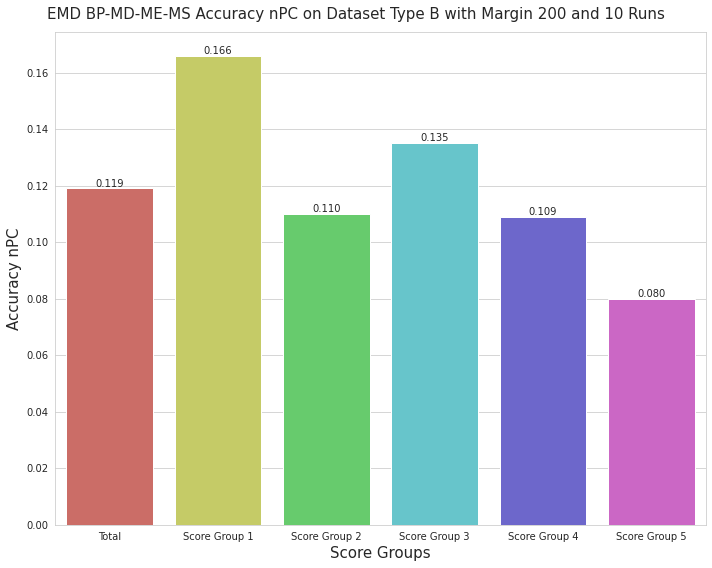

In [102]:
plot_nucleotide_accuracies(predictions_df)

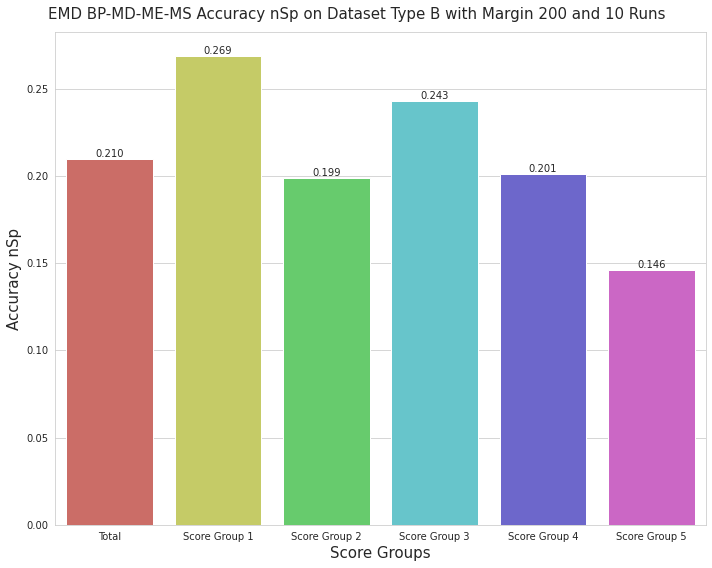

In [103]:
plot_nucleotide_accuracies(predictions_df, 'nSp')

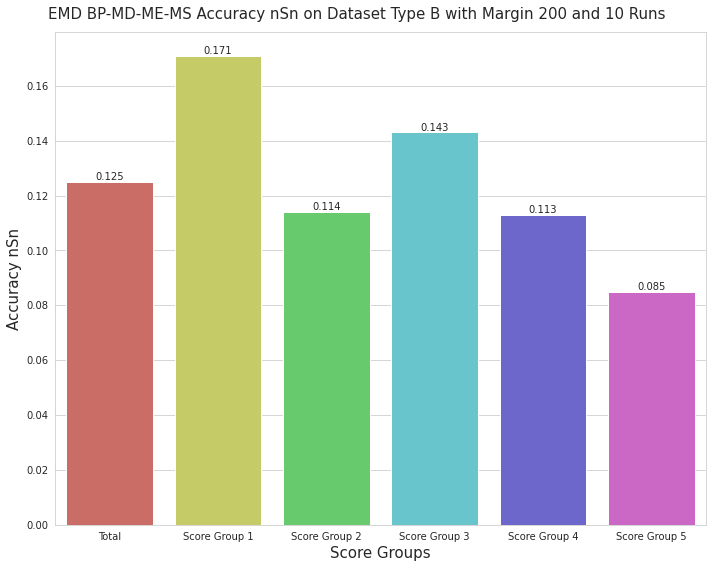

In [104]:
plot_nucleotide_accuracies(predictions_df, 'nSn')

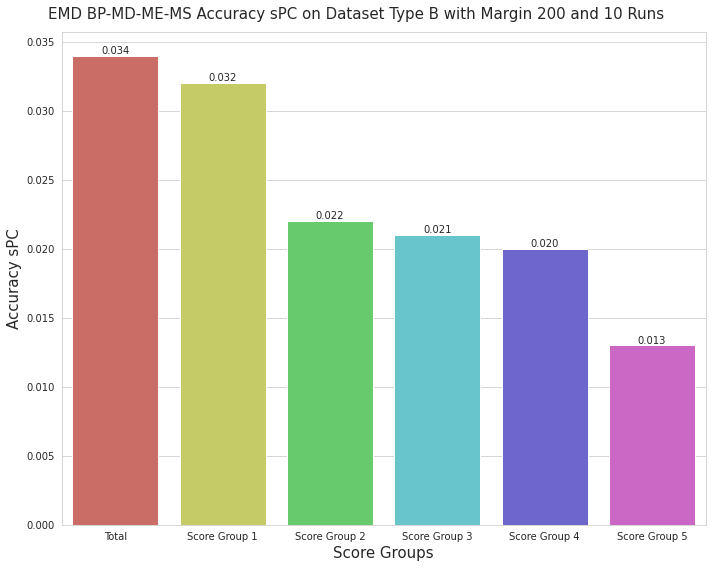

In [105]:
plot_site_accuracies(predictions_df)

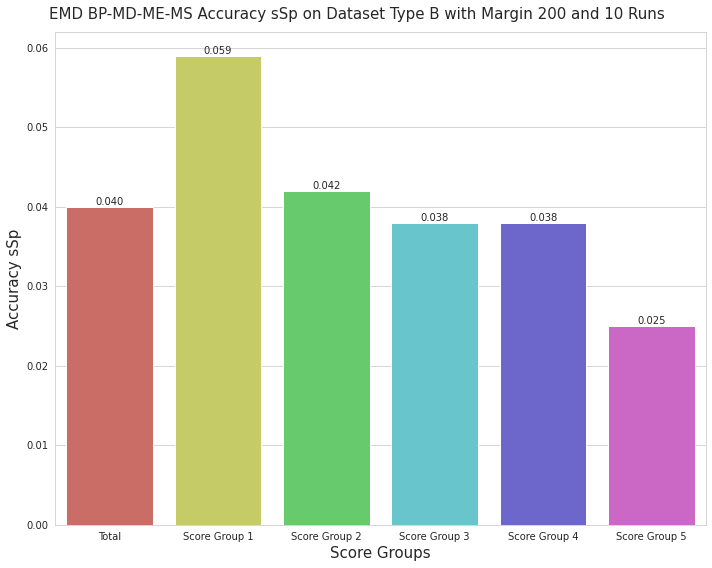

In [106]:
plot_site_accuracies(predictions_df, 'sSp')

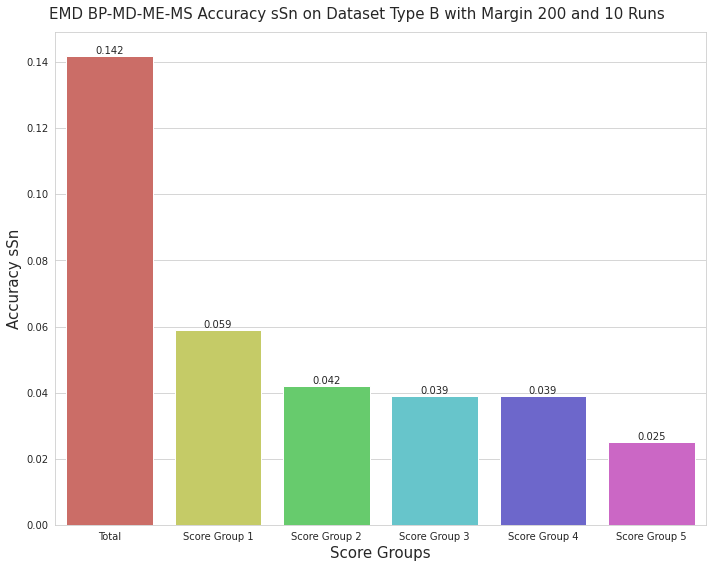

In [107]:
plot_site_accuracies(predictions_df, 'sSn')
